In [10]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torchnlp.datasets import multi30k_dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train = multi30k_dataset(train=True)
validation = multi30k_dataset(dev=True)
test = multi30k_dataset(test=True)

## Loading data file
file format: 
[{'en': 'A man in an orange hat starring at something.', 
'de': 'Ein Mann mit einem orangefarbenen Hut, der etwas anstarrt.'}, {}]

1. add SOS EOS
2. From unicode to acsii, delete lower case and trim punctuation.

In [13]:
SOS_token = 0
EOS_token = 1
MAX_LENGTH = 15

# build the dictionary
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

def buildLangs(train, validation, test, reverse=False):
    """ build Language dictionary
    Input: set and reverse flag. Default file from Eng>De.
        If we want to translate De->Eng, set reverse=True
    Output: two language dictionary class from training set
    """
    train_pairs = [[normalizeString(pair['en']), normalizeString(pair['de'])] \
        for pair in train[0:1000]]
    # TODO: use all data

    if reverse:
        train_pairs = [list(reversed(pair)) for pair in train_pairs]
        input_lang = Lang('en')
        output_lang = Lang('de')
    else: 
        input_lang = Lang('de')
        output_lang = Lang('en')
    return input_lang, output_lang, train_pairs

def prepareData(reverse=False):
    input_lang, output_lang, pairs = buildLangs(train, validation, test, reverse)
    print("Read %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData(reverse=True)
print(random.choice(pairs))

Read 1000 sentence pairs
Counting words...
Counted words:
en 2176
de 1842
['ein mann der einen anderen mann auf die wange kusst und beide tragen wei e hemden mit schwarzen westen .', 'one man kissing another man on the check and both are in white shirts with black vests .']


## Encoder and Decoder layer
A RNN network. Each timestep, input a word and then output a hidden state which used in next timestep input word. Need to implement forward calculation.

In [14]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size) 
        self.gru = nn.GRU(hidden_size, hidden_size) # gated recurrent unit

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1) # TODO: why?
        output =embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

class AttnDecoder(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super().__init__()
        self.hidden_size = hidden_sizes
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        # TODO: figure out how to determine the size
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size*2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size*2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1,1,-1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

# Training
## Prepare the training data
Set the word to the index tensor.

In [ ]:
# get index of word in sentence from dictionary
def indexFromSentence(lang, sentence):
    return [lang.word2index(word) for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

# return index tensor for pair
def tensorFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [ ]:
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length = MAX_LENGTH):
    encoder_hidden = encoder.initHidden()
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    output_length = output_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        enocoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_outputs[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)
    decoder_hidden = encoder_hidden

    use_teacher = True if random.random() < teacher_forcing_ratio else False

    if use_teacher:
        for de in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[de])
            decoder_input = target_tensor[de]
    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()
        return loss.item() / target_length

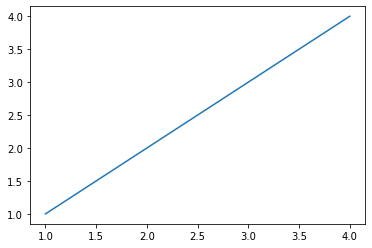

In [17]:
import matplotlib.pyplot as plt
ten = torch.rand(2,3)
tenx = ten.view(1,1,-1)
x = [1,2,3,4]
y = [1,2,3,4]
plt.plot(x,y)
plt.show()